In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [ ]:

# Load the data
df = pd.read_csv('llm_scoring_results_+same_language.csv')

In [ ]:
df.head()

,row_index,question_id,llm,score,page,QA_same_language,Language
0,0,q1_1,Claude,5,0,yes,en
1,5,q2_1,Claude,1,0,yes,fr
2,10,q3_1,Claude,1,0,yes,nl
3,15,q4_1,Claude,1,0,yes,de
4,1,q1_1,GPT,5,1,yes,en


In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency, pointbiserialr
import matplotlib.pyplot as plt
import seaborn as sns


# Convert 'QA_same_language' to boolean
df['same_language'] = df['QA_same_language'].map({'yes': True, 'no': False})

# Define a custom color palette for the models
model_palette = {
    "Claude": "#1f77b4",
    "Cohere": "#ff7f0e",
    "GPT": "#2ca02c",
    "Mistral": "#d62728",
    "Deepseek": "#9467bd"
}

# Define a color palette for languages
language_palette = {
    "en": "#1abc9c",  # Turquoise
    "fr": "#3498db",  # Blue
    "nl": "#9b59b6",  # Purple
    "de": "#f1c40f"  # Yellow
}




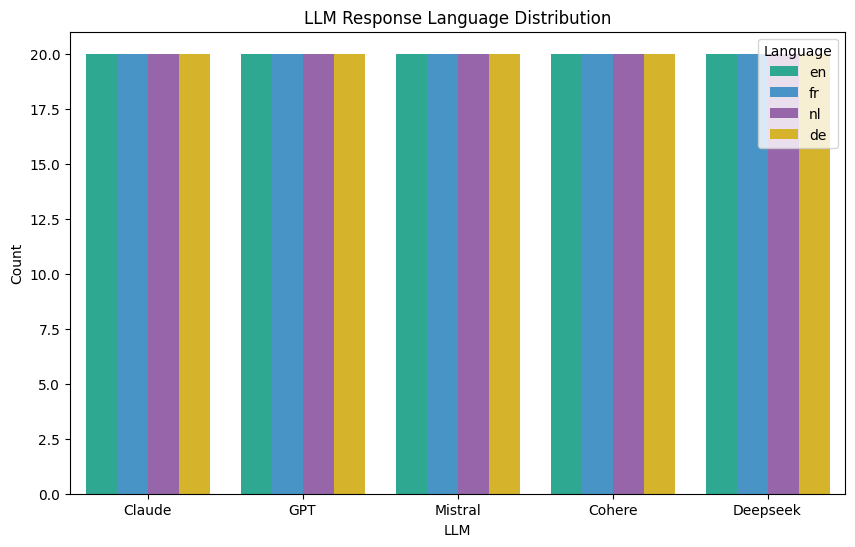

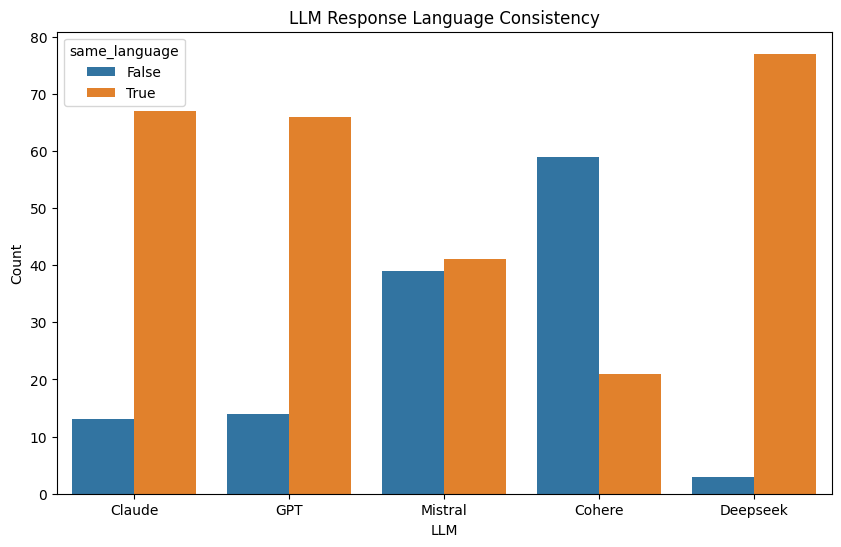

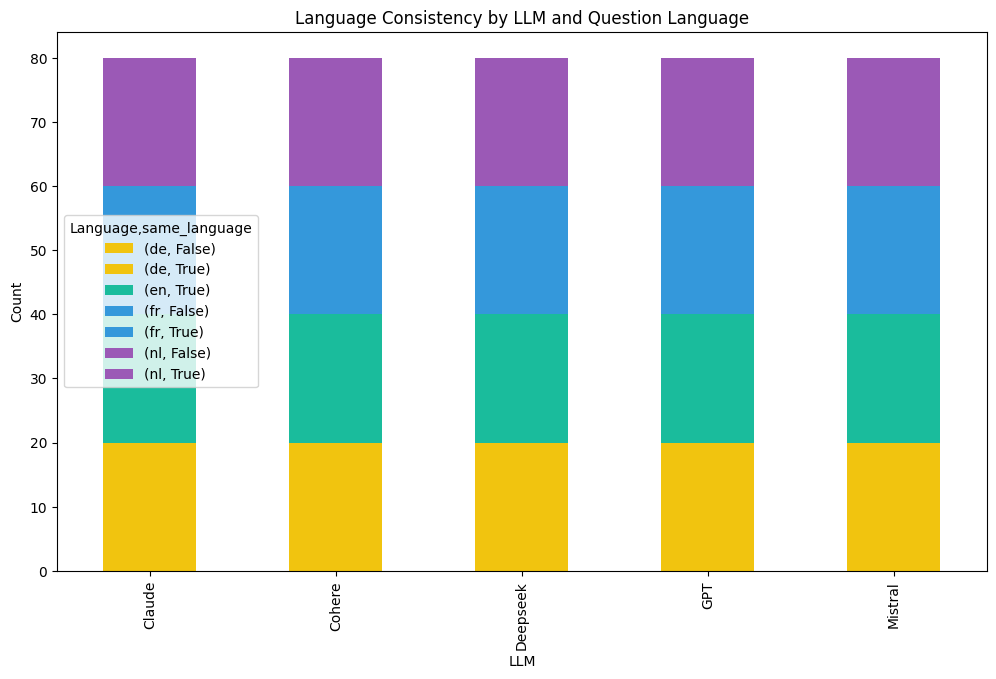

In [ ]:
# 1. Bar plot of LLM and Language
plt.figure(figsize=(10, 6))
sns.countplot(x='llm', hue='Language', data=df, palette=language_palette)
plt.title('LLM Response Language Distribution')
plt.xlabel('LLM')
plt.ylabel('Count')
plt.show()

# 2. Bar plot of LLM and Same Language
plt.figure(figsize=(10, 6))
sns.countplot(x='llm', hue='same_language', data=df)
plt.title('LLM Response Language Consistency')
plt.xlabel('LLM')
plt.ylabel('Count')
plt.show()

# 3. Stacked bar chart
cross_tab = pd.crosstab(df['llm'], [df['Language'], df['same_language']])
cross_tab.plot(kind='bar', stacked=True, figsize=(12, 7), color=[language_palette[col[0]] for col in cross_tab.columns])
plt.title('Language Consistency by LLM and Question Language')
plt.xlabel('LLM')
plt.ylabel('Count')
plt.show()



In [ ]:
# 4. Chi-Square Test
contingency_table = pd.crosstab(df['llm'], df['same_language'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Test:\nChi2 = {chi2}, p = {p}, DOF = {dof}")

# 5. Point-Biserial Correlation
correlation, p_value = pointbiserialr(df['same_language'], df['score'])
print(f"\nPoint-Biserial Correlation:\nCorrelation = {correlation}, p-value = {p_value}")

Chi-Square Test:
Chi2 = 120.58823529411762, p = 3.9995968000407885e-25, DOF = 4

Point-Biserial Correlation:
Correlation = 0.816111756739088, p-value = 8.036067756638763e-97


In [ ]:
# 6. Analyze LLM behavior
language_bias = df.groupby('llm').agg(
    total_responses=('question_id', 'count'),
    same_language_responses=('same_language', 'sum'),
    english_responses=('Language', lambda x: (x == 'en').sum())
).reset_index()

language_bias['same_language_ratio'] = language_bias['same_language_responses'] / language_bias['total_responses']
language_bias['english_ratio'] = language_bias['english_responses'] / language_bias['total_responses']

print("\nLLM Language Bias Analysis:")
print(language_bias)

# Find if LLM answers in English when the question is not in English.
for llm in df['llm'].unique():
    non_english_questions = df[(df['llm'] == llm) & (df['Language'] != 'en')]
    english_answers_count = non_english_questions['Language'].value_counts().get('en', 0)
    total_non_english_questions = len(non_english_questions)

    if total_non_english_questions > 0:
        english_answer_ratio = (english_answers_count / total_non_english_questions)
        print(f"\n{llm} answered in English {english_answers_count} out of {total_non_english_questions} times when the question was not in English ({english_answer_ratio:.2f} ratio)")
    else:
        print(f"\n{llm} did not receive any non-English questions.")


LLM Language Bias Analysis:
        llm  total_responses  same_language_responses  english_responses  \
0    Claude               80                       67                 20   
1    Cohere               80                       21                 20   
2  Deepseek               80                       77                 20   
3       GPT               80                       66                 20   
4   Mistral               80                       41                 20   

   same_language_ratio  english_ratio  
0               0.8375           0.25  
1               0.2625           0.25  
2               0.9625           0.25  
3               0.8250           0.25  
4               0.5125           0.25  

Claude answered in English 0 out of 60 times when the question was not in English (0.00 ratio)

GPT answered in English 0 out of 60 times when the question was not in English (0.00 ratio)

Mistral answered in English 0 out of 60 times when the question was not in English (

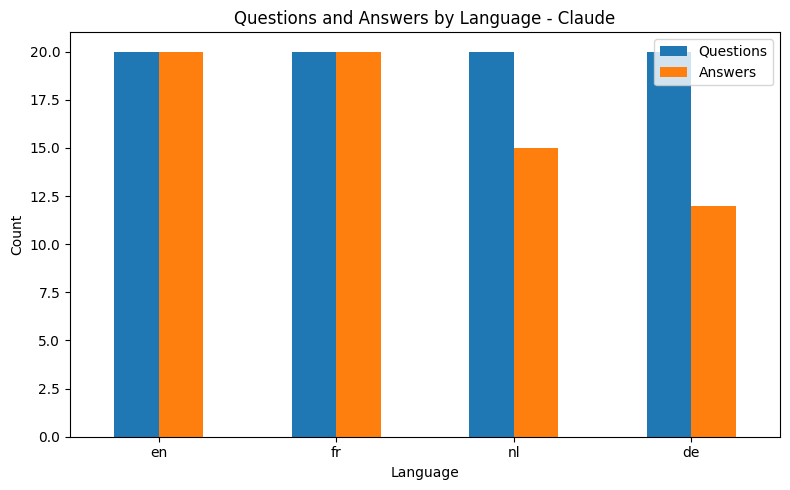

<Figure size 640x480 with 0 Axes>

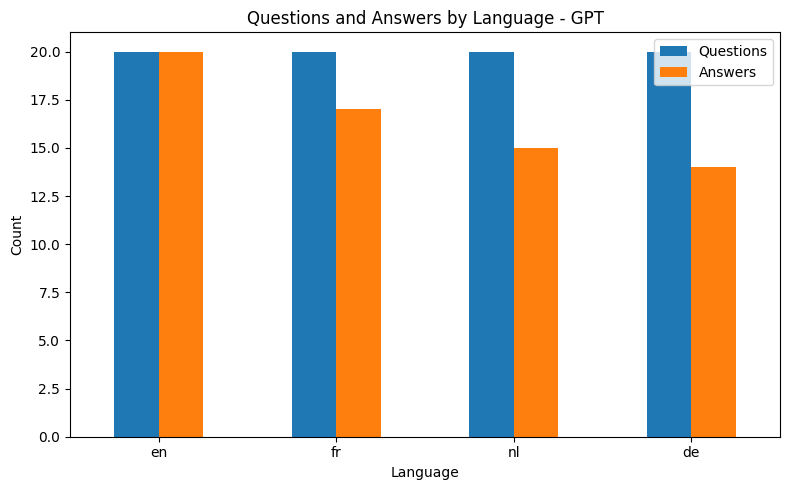

<Figure size 640x480 with 0 Axes>

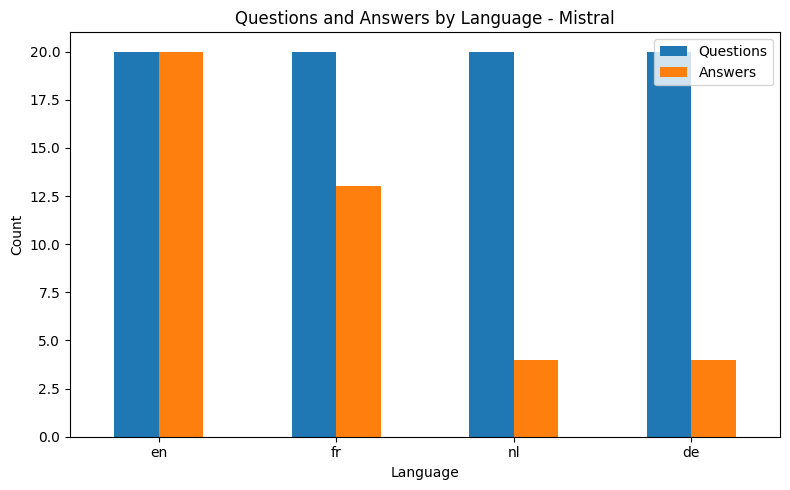

<Figure size 640x480 with 0 Axes>

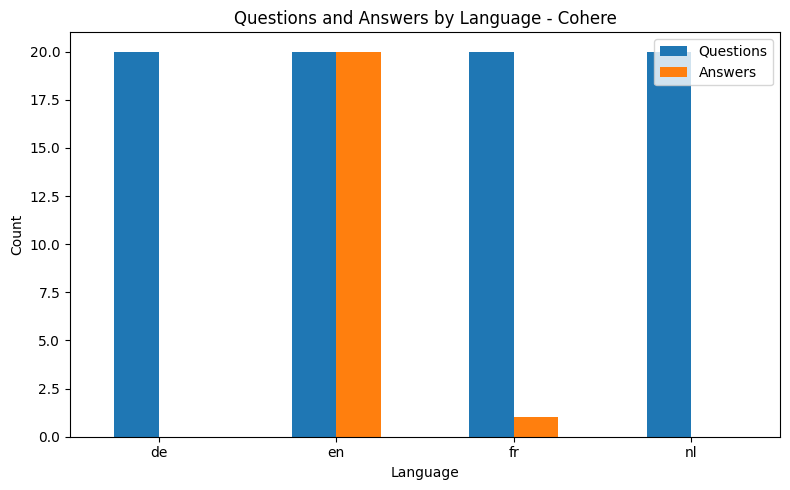

<Figure size 640x480 with 0 Axes>

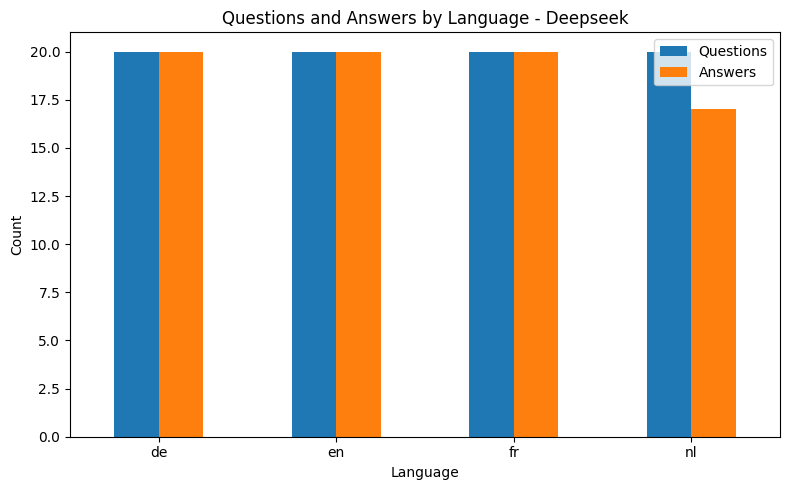

<Figure size 640x480 with 0 Axes>

In [ ]:

# Initialize results
results = []

# Loop through each LLM
for llm_name in df['llm'].unique():
    subset = df[df['llm'] == llm_name]

    # Count questions by language
    question_counts = subset['Language'].value_counts()

    # If QA_same_language == 'yes', answers are in the same language
    # So we count the same way for answers
    answer_counts = subset[subset['QA_same_language'] == 'yes']['Language'].value_counts()

    # Combine into a DataFrame
    combined = pd.DataFrame({
        'Questions': question_counts,
        'Answers': answer_counts
    }).fillna(0).astype(int)

    results.append((llm_name, combined))

# Plot for each LLM
for llm_name, counts_df in results:
    counts_df.plot(kind='bar', figsize=(8, 5))
    plt.title(f'Questions and Answers by Language - {llm_name}')
    plt.xlabel('Language')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    plt.savefig("language"+llm_name+".png")

        llm  total_questions  same_language_answers  percentage_same_language  \
0    Claude               80                     67                     83.75   
1       GPT               80                     66                     82.50   
2   Mistral               80                     41                     51.25   
3    Cohere               80                     21                     26.25   
4  Deepseek               80                     77                     96.25   

   chi2_statistic       p_value  degrees_of_freedom  \
0       17.175660  6.503170e-04                   3   
1        7.272727  6.369481e-02                   3   
2       36.172608  6.884807e-08                   3   
3       75.092817  3.461094e-16                   3   
4        9.350649  2.497445e-02                   3   

                                   contingency_table  
0  QA_same_language  no  yes
Language            ...  
1  QA_same_language  no  yes
Language            ...  
2  QA_same_langua

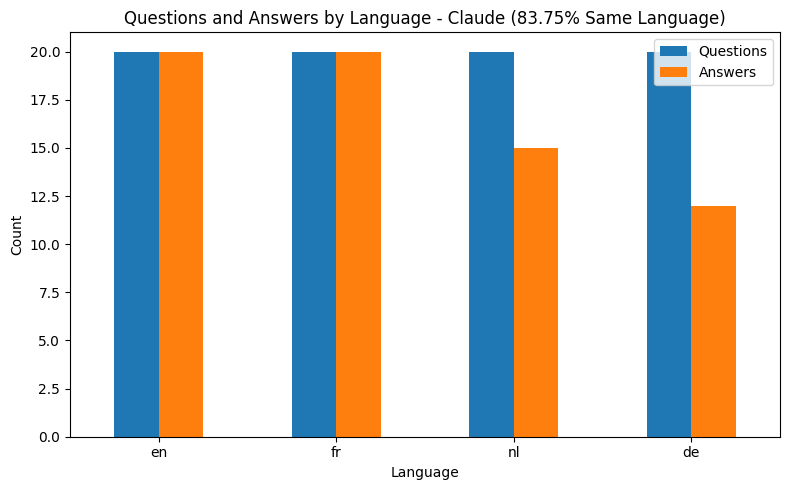

<Figure size 640x480 with 0 Axes>

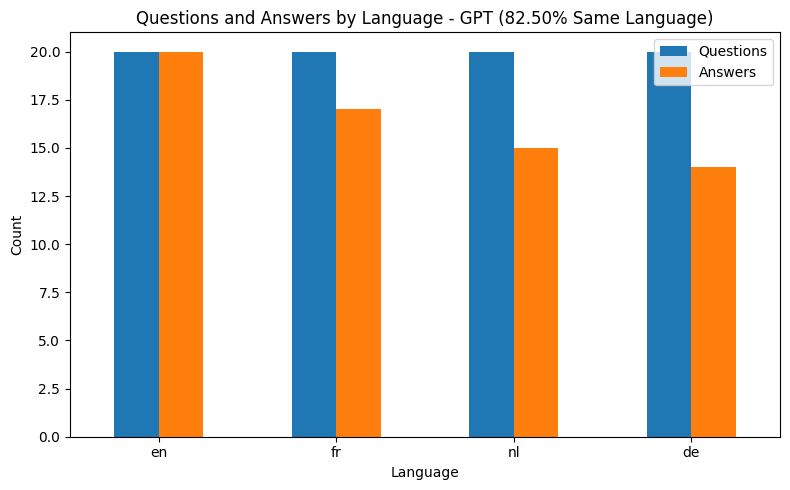

<Figure size 640x480 with 0 Axes>

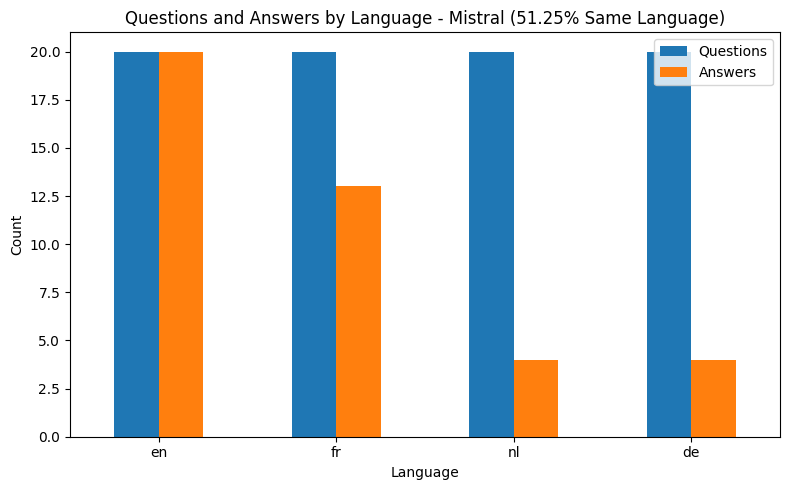

<Figure size 640x480 with 0 Axes>

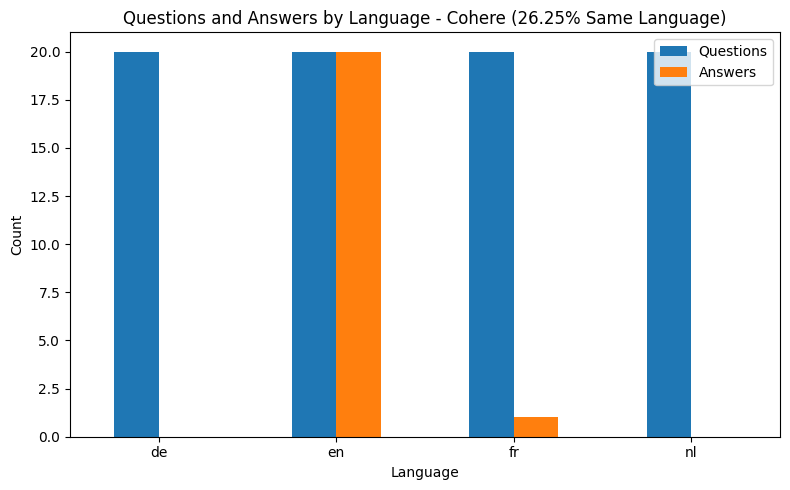

<Figure size 640x480 with 0 Axes>

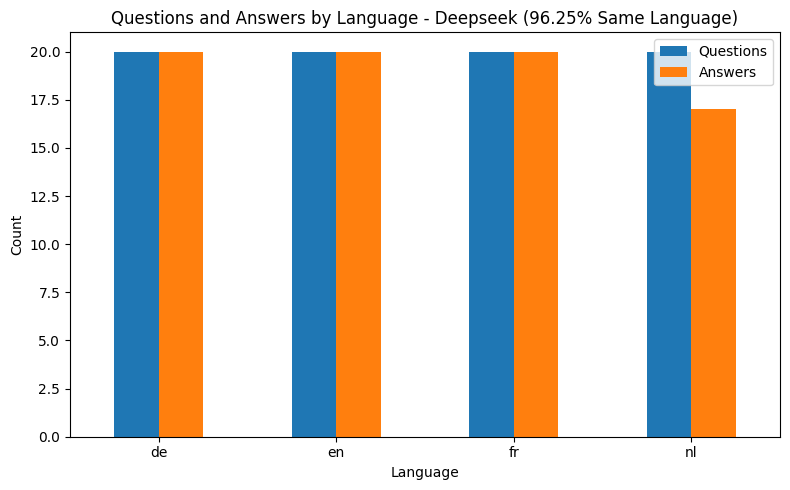

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Assuming your dataframe is named 'df'
# Make sure 'df' contains the columns: 'llm', 'Language', 'QA_same_language'

# Initialize results list to store calculations for each LLM
results = []

# Loop through each LLM in the dataframe
for llm_name in df['llm'].unique():
    subset = df[df['llm'] == llm_name]

    # 1. Calculate percentage of answers in the same language:
    total_questions = len(subset)
    same_language_answers = len(subset[subset['QA_same_language'] == 'yes'])
    percentage_same_language = (same_language_answers / total_questions) * 100 if total_questions else 0

    # 2. Perform Chi-Square test for independence:
    # Create a contingency table:
    contingency_table = pd.crosstab(subset['Language'], subset['QA_same_language'])

    # Perform the Chi-Square test:
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Store the results:
    results.append({
        'llm': llm_name,
        'total_questions': total_questions,
        'same_language_answers': same_language_answers,
        'percentage_same_language': percentage_same_language,
        'chi2_statistic': chi2,
        'p_value': p,
        'degrees_of_freedom': dof,
        'contingency_table': contingency_table # Store the table, useful for debugging/further analysis
    })

# Convert results to a DataFrame for easier viewing and manipulation:
results_df = pd.DataFrame(results)

# Print the results DataFrame:
print(results_df)

# Now, you can iterate through the results_df to access the information for each LLM.
# For example, to print the percentage for each LLM:
for index, row in results_df.iterrows():
    print(f"LLM: {row['llm']}, Percentage of answers in the same language: {row['percentage_same_language']:.2f}%")

# If you want to check the statistical significance:
for index, row in results_df.iterrows():
    print(f"LLM: {row['llm']}, Chi2 Statistic: {row['chi2_statistic']:.2f}, P-value: {row['p_value']:.3f}")
    if row['p_value'] < 0.05:
        print("   The difference in distribution of same language answers across languages is statistically significant.")
    else:
        print("   There is no significant difference in the distribution of same language answers across languages.")


# 3.  Visualization (Bar Chart - Modified to include percentage in title)
for result in results: # Iterate through the results list
    llm_name = result['llm']
    counts_df = pd.DataFrame({
        'Questions': df[df['llm'] == llm_name]['Language'].value_counts(),
        'Answers': df[(df['llm'] == llm_name) & (df['QA_same_language'] == 'yes')]['Language'].value_counts()
    }).fillna(0).astype(int)
    percentage = result['percentage_same_language']

    counts_df.plot(kind='bar', figsize=(8, 5))
    plt.title(f'Questions and Answers by Language - {llm_name} ({percentage:.2f}% Same Language)') # Include percentage in title
    plt.xlabel('Language')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    plt.savefig(f"language_{llm_name}.png")

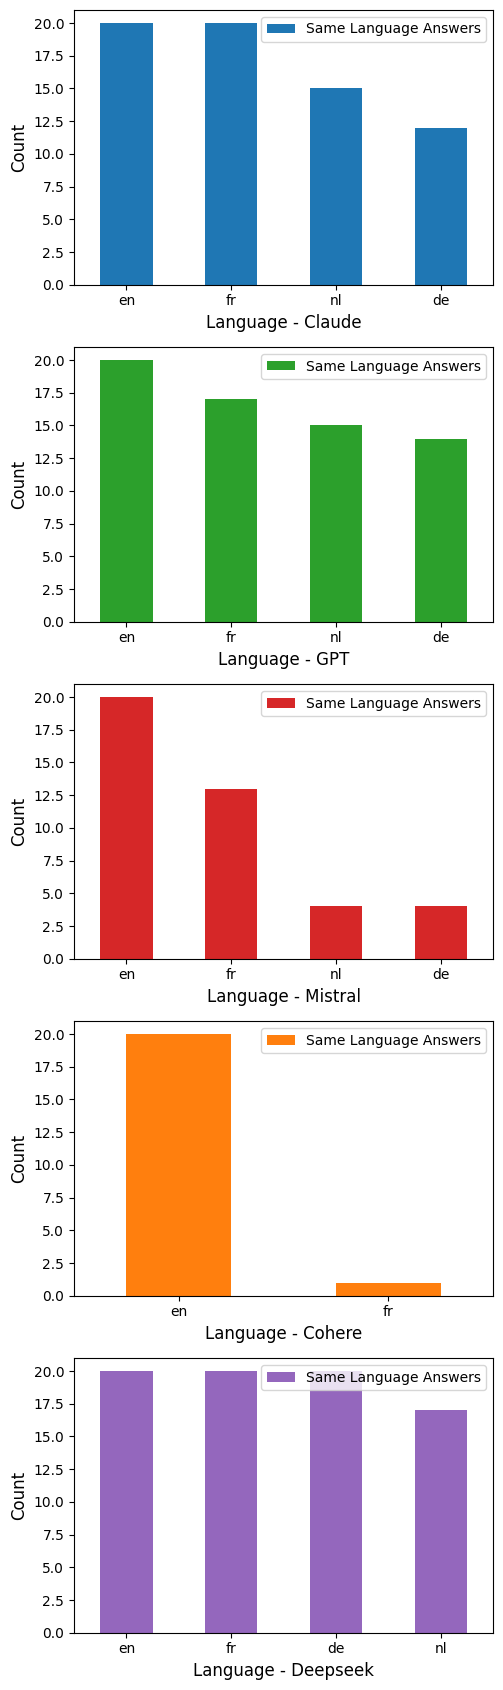

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define a custom colour palette for the models
model_palette = {
    "Claude": "#1f77b4",    # Blue
    "Cohere": "#ff7f0e",    # Orange
    "GPT": "#2ca02c",       # Green
    "Mistral": "#d62728",   # Red
    "Deepseek": "#9467bd"   # Purple
}

# Create subplots (1 column, len(results) rows, one for each LLM)
fig, axes = plt.subplots(len(results), 1, figsize=(5, 28))  # Adjust size based on number of LLMs

# Iterate through the results list and plot each LLM's data
for i, result in enumerate(results):
    llm_name = result['llm']

    # Prepare the data
    counts_df = pd.DataFrame({
       # 'Questions': df[df['llm'] == llm_name]['Language'].value_counts(),
        'Same Language Answers': df[(df['llm'] == llm_name) & (df['QA_same_language'] == 'yes')]['Language'].value_counts()
    }).fillna(0).astype(int)

    # Calculate the percentage of same language answers
    percentage = result['percentage_same_language']

    # Plot on the corresponding subplot
    ax = axes[i]  # Select the appropriate axis for this LLM
    counts_df.plot(kind='bar', ax=ax, figsize=(5, 17), color=[model_palette.get(llm_name, '#1f77b4')])  # Set the color for answers

    # Set the xlabel and ylabel with proper formatting
    ax.set_xlabel(f'Language - {llm_name}', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)

    # Add title to each subplot
   # ax.set_title(f'{llm_name} ({percentage:.2f}% Same Language)', fontsize=14)

    # Set the x-tick labels with proper rotation
    ax.set_xticklabels(counts_df.index, rotation=0)

# Adjust layout to fit the subplots neatly
plt.tight_layout()

# Save the combined plot to a file
plt.savefig("language_all_llms_subplot.png", dpi=300)

# Show the plot
plt.show()




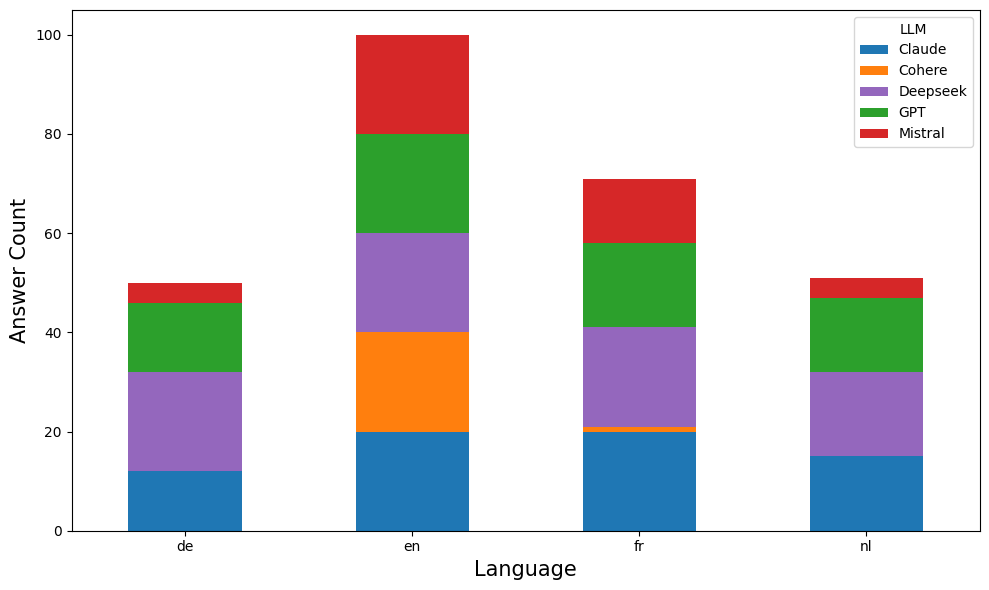

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define a custom colour palette for the models
model_palette = {
    "Claude": "#1f77b4",    # Blue
    "Cohere": "#ff7f0e",    # Orange
    "GPT": "#2ca02c",       # Green
    "Mistral": "#d62728",   # Red
    "Deepseek": "#9467bd"   # Purple
}

# Create a dataframe with counts of same-language answers for each LLM
answer_counts = df[df['QA_same_language'] == 'yes'].groupby(['llm', 'Language']).size().unstack(fill_value=0)

# Plot a stacked bar chart
ax = answer_counts.T.plot(kind='bar', stacked=True, figsize=(10, 6), color=[model_palette.get(llm, '#333333') for llm in answer_counts.index])

# Customize the plot
#plt.title("Same Language Answers by LLM and Language", fontsize=14)
plt.xlabel("Language", fontsize=15)
plt.ylabel("Answer Count", fontsize=15)
plt.xticks(rotation=0)
plt.legend(title='LLM')
plt.tight_layout()

# Save the figure
plt.savefig("stacked_answers_by_llm.png", dpi=300)

# Show the plot
plt.show()


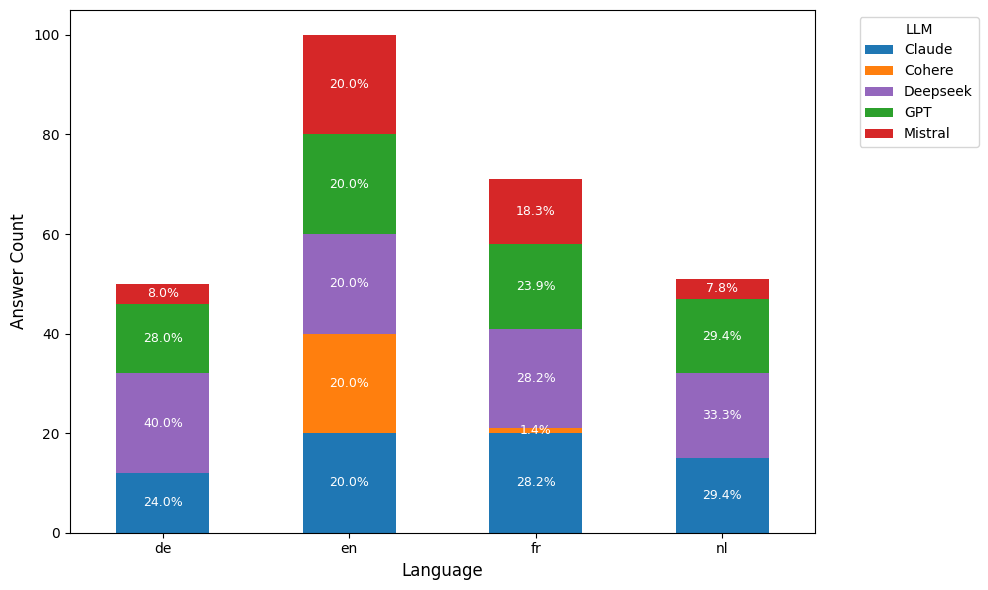

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define custom color palette
model_palette = {
    "Claude": "#1f77b4",
    "Cohere": "#ff7f0e",
    "GPT": "#2ca02c",
    "Mistral": "#d62728",
    "Deepseek": "#9467bd"
}

# Step 1: Create answer counts DataFrame (Same Language only)
answer_counts = df[df['QA_same_language'] == 'yes'].groupby(['llm', 'Language']).size().unstack(fill_value=0)

# Step 2: Transpose to get languages on x-axis
answer_counts = answer_counts.T

# Step 3: Plot the stacked bar chart
ax = answer_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=[model_palette.get(llm, '#333333') for llm in answer_counts.columns])

# Step 4: Add percentage labels to each stack segment
for i, lang in enumerate(answer_counts.index):  # Loop over each language (x-axis category)
    total = answer_counts.loc[lang].sum()
    bottom = 0
    for llm in answer_counts.columns:
        value = answer_counts.loc[lang, llm]
        if value > 0:
            percentage = value / total * 100
            ax.text(i, bottom + value / 2, f'{percentage:.1f}%', ha='center', va='center', fontsize=9, color='white')
            bottom += value

# Customize plot
#plt.title("Same Language Answers by LLM and Language", fontsize=14)
plt.xlabel("Language", fontsize=12)
plt.ylabel("Answer Count", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='LLM', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save and show
plt.savefig("stacked_answers_by_llm_with_percentages.png", dpi=300)
plt.show()


In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# Container for chi-square results per LLM
chi2_language_results = []

# Loop over each LLM
for llm_name in df['llm'].unique():
    subset = df[df['llm'] == llm_name]

    # Contingency table: rows = Language, columns = QA_same_language (yes/no)
    contingency_table = pd.crosstab(subset['Language'], subset['QA_same_language'])

    # Only proceed if table is valid (at least 2 rows and 2 columns)
    if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        chi2_language_results.append({
            'llm': llm_name,
            'chi2_statistic': chi2,
            'p_value': p,
            'degrees_of_freedom': dof,
            'contingency_table': contingency_table
        })

        print(f"\nLLM: {llm_name}")
        print("Contingency Table:")
        print(contingency_table)
        print(f"Chi² = {chi2:.2f}, p = {p:.4f}, dof = {dof}")
        if p < 0.05:
            print("→ Statistically significant difference in same-language answering across languages.")
        else:
            print("→ No significant difference in same-language answering across languages.")
    else:
        print(f"\nLLM: {llm_name} — Not enough data for Chi² test.")



LLM: Claude
Contingency Table:
QA_same_language  no  yes
Language                 
de                 8   12
en                 0   20
fr                 0   20
nl                 5   15
Chi² = 17.18, p = 0.0007, dof = 3
→ Statistically significant difference in same-language answering across languages.

LLM: GPT
Contingency Table:
QA_same_language  no  yes
Language                 
de                 6   14
en                 0   20
fr                 3   17
nl                 5   15
Chi² = 7.27, p = 0.0637, dof = 3
→ No significant difference in same-language answering across languages.

LLM: Mistral
Contingency Table:
QA_same_language  no  yes
Language                 
de                16    4
en                 0   20
fr                 7   13
nl                16    4
Chi² = 36.17, p = 0.0000, dof = 3
→ Statistically significant difference in same-language answering across languages.

LLM: Cohere
Contingency Table:
QA_same_language  no  yes
Language                 
de          

In [ ]:
df.head()

,row_index,question_id,llm,score,page,QA_same_language,Language
0,0,q1_1,Claude,5,0,yes,en
1,5,q2_1,Claude,1,0,yes,fr
2,10,q3_1,Claude,1,0,yes,nl
3,15,q4_1,Claude,1,0,yes,de
4,1,q1_1,GPT,5,1,yes,en


In [ ]:

# Convert QA_same_language to boolean for easier analysis
df['same_language'] = df['QA_same_language'].map({'yes': True, 'no': False})

In [ ]:

# Define a custom colour palette for the models
model_palette = {
    "Claude": "#1f77b4",    # Blue
    "Cohere": "#ff7f0e",    # Orange
    "GPT": "#2ca02c",       # Green
    "Mistral": "#d62728",   # Red
    "Deepseek": "#9467bd"   # Purple
}


<ipython-input-12-2d5ec1b9741c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='llm', y='score', data=df, palette=model_palette)


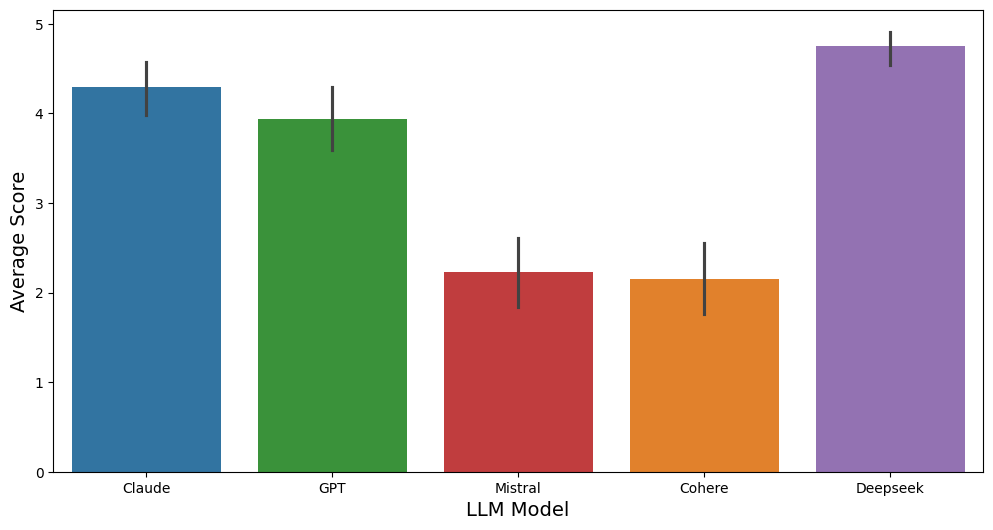

In [ ]:


# 1. Performance Comparison by LLM
plt.figure(figsize=(12, 6))
sns.barplot(x='llm', y='score', data=df, palette=model_palette)
#plt.title('Average Score by LLM', fontsize=16)
plt.xlabel('LLM Model', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.savefig('avg_score_by_llm.png', dpi=300, bbox_inches='tight')


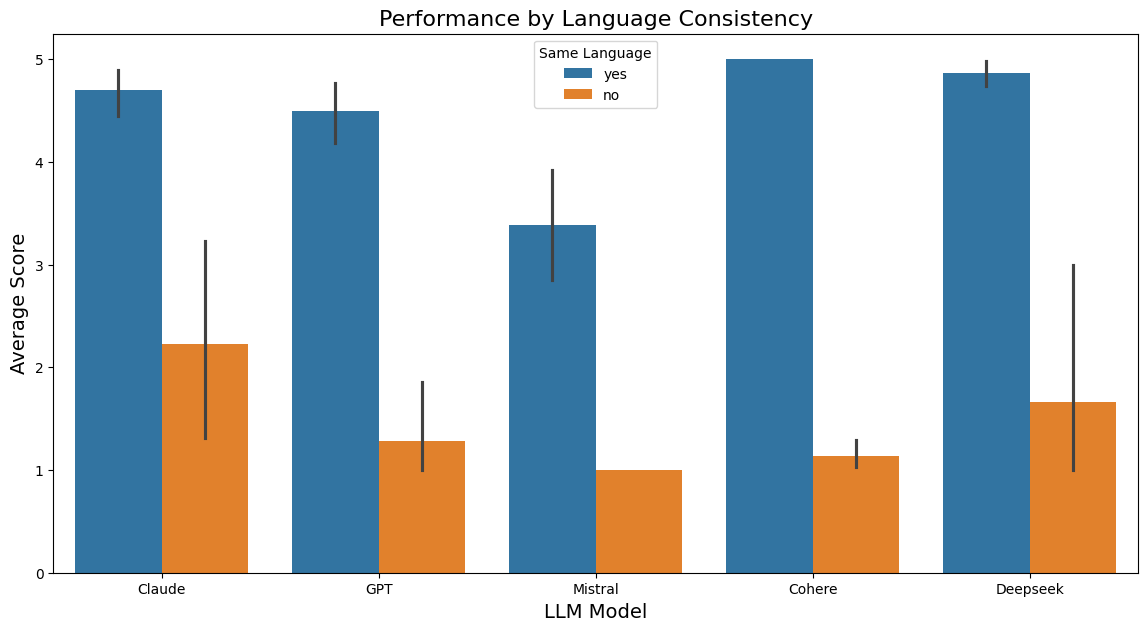

In [ ]:


# 2. Language Consistency Analysis
plt.figure(figsize=(14, 7))
sns.barplot(x='llm', y='score', hue='QA_same_language', data=df)
plt.title('Performance by Language Consistency', fontsize=16)
plt.xlabel('LLM Model', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.legend(title='Same Language')
plt.savefig('performance_by_language_consistency.png', dpi=300, bbox_inches='tight')

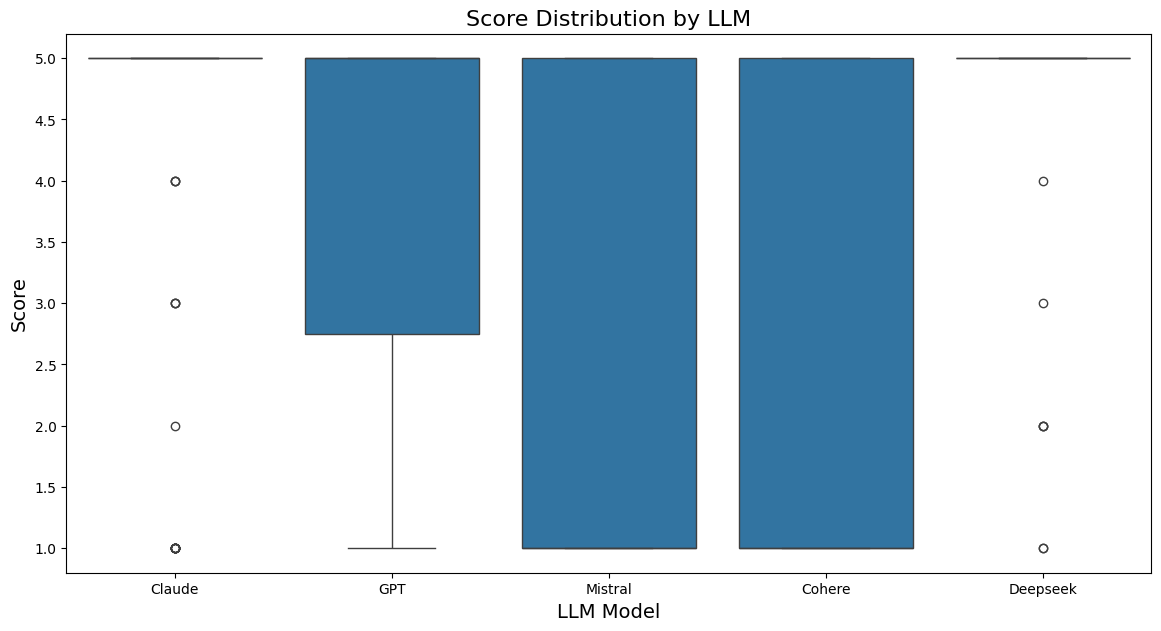

In [ ]:
# 3. Score Distribution Visualization
plt.figure(figsize=(14, 7))
sns.boxplot(x='llm', y='score', data=df)
plt.title('Score Distribution by LLM', fontsize=16)
plt.xlabel('LLM Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.savefig('score_distribution.png', dpi=300, bbox_inches='tight')


In [ ]:
df.head()

,row_index,question_id,llm,score,page,QA_same_language,Language,same_language
0,0,q1_1,Claude,5,0,yes,en,True
1,5,q2_1,Claude,1,0,yes,fr,True
2,10,q3_1,Claude,1,0,yes,nl,True
3,15,q4_1,Claude,1,0,yes,de,True
4,1,q1_1,GPT,5,1,yes,en,True


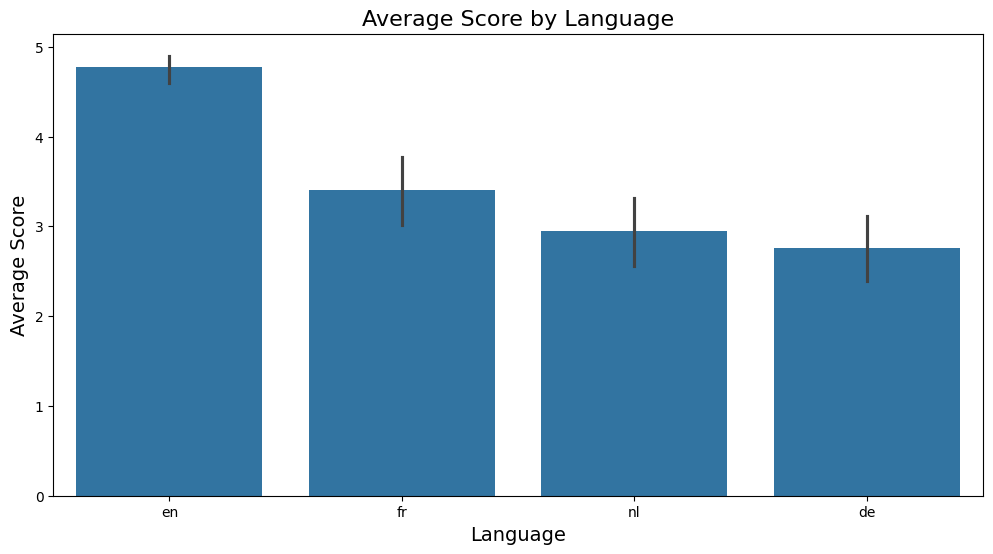

In [ ]:
# 1. Performance by Language
plt.figure(figsize=(12, 6))
sns.barplot(x='Language', y='score', data=df)
plt.title('Average Score by Language', fontsize=16)
plt.xlabel('Language', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.savefig('avg_score_by_language.png', dpi=300, bbox_inches='tight')

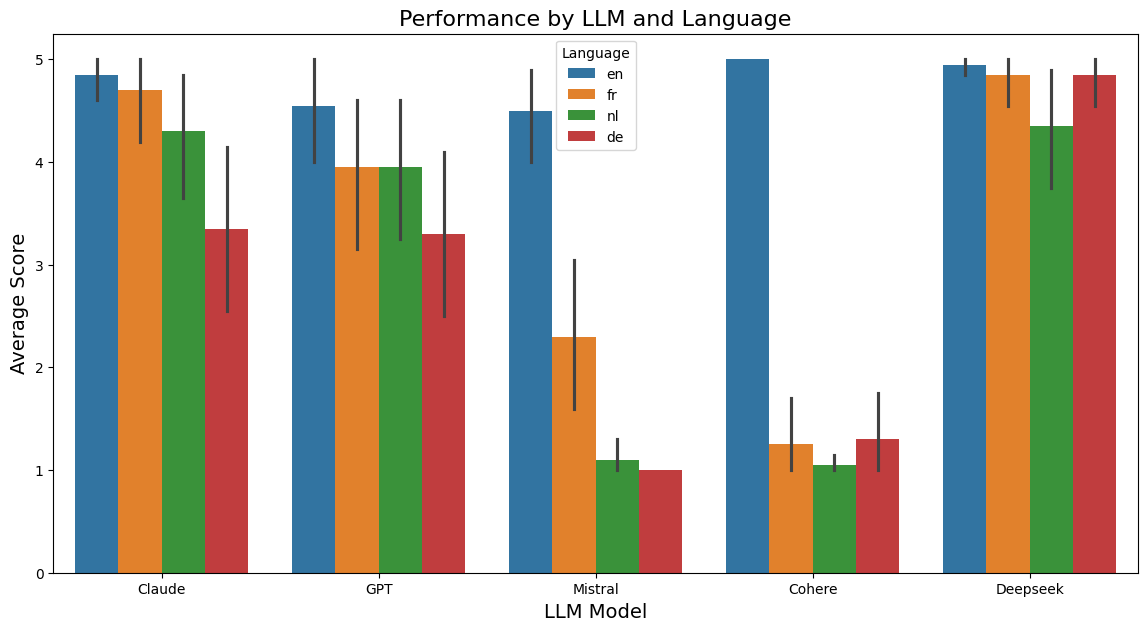

In [ ]:
plt.figure(figsize=(14, 7))
sns.barplot(x='llm', y='score', hue='Language', data=df)
plt.title('Performance by LLM and Language', fontsize=16)
plt.xlabel('LLM Model', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.legend(title='Language')
plt.savefig('performance_by_llm_and_language.png', dpi=300, bbox_inches='tight')

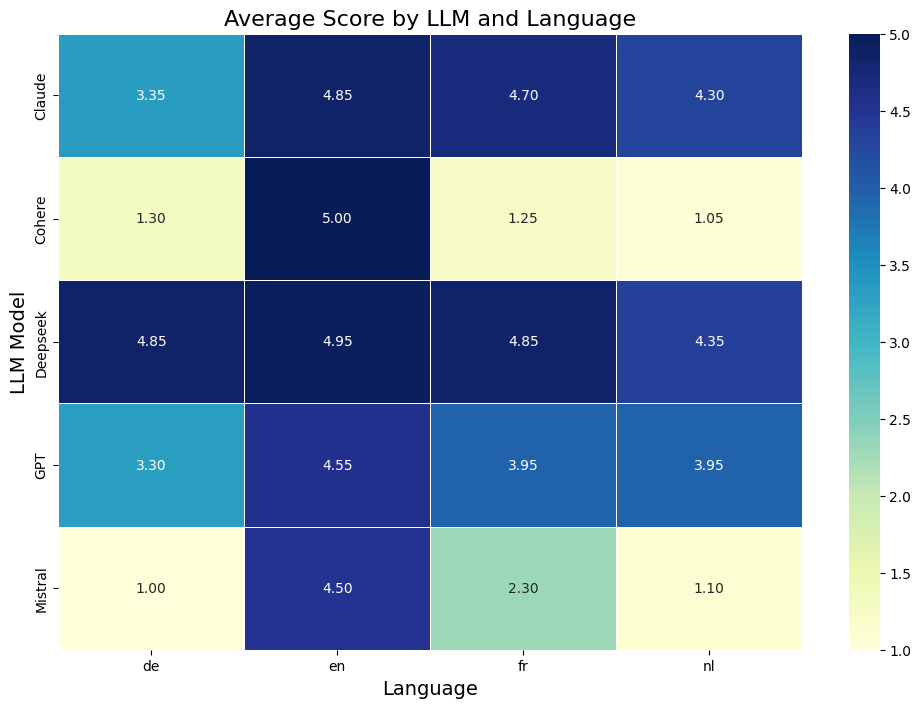

In [ ]:
# 3. Heat Map of Language Performance
pivot_lang = df.pivot_table(values='score', index='llm', columns='Language', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_lang, annot=True, cmap='YlGnBu', linewidths=.5, fmt='.2f')
plt.title('Average Score by LLM and Language', fontsize=16)
plt.xlabel('Language', fontsize=14)
plt.ylabel('LLM Model', fontsize=14)
plt.savefig('language_performance_heatmap.png', dpi=300, bbox_inches='tight')

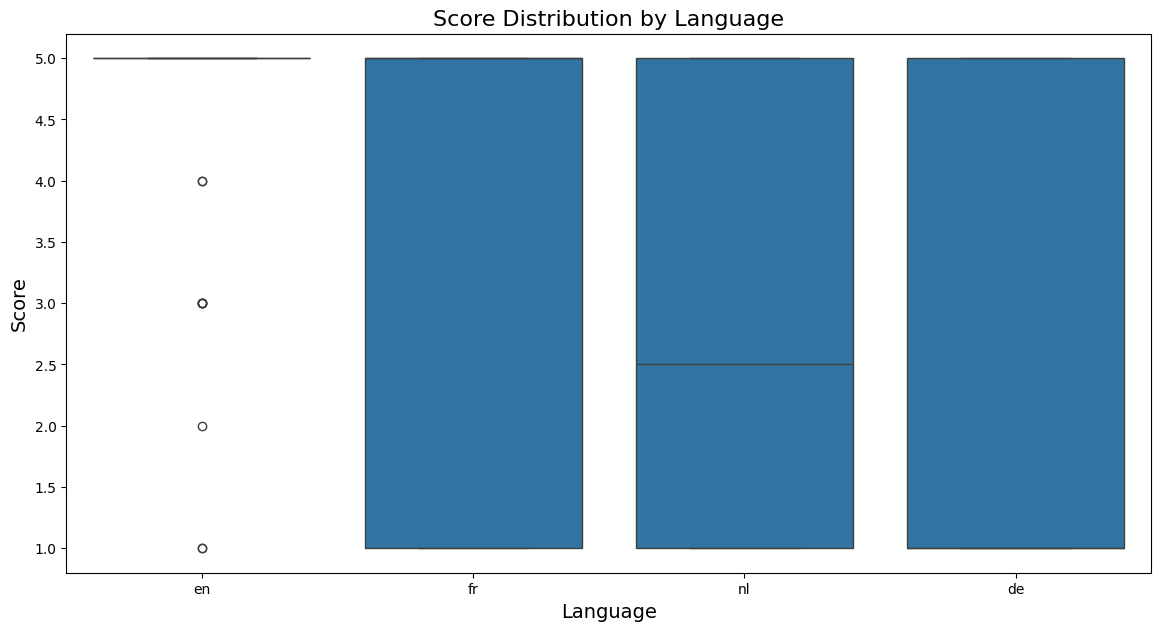

In [ ]:
 #4. Performance Distribution by Language
plt.figure(figsize=(14, 7))
sns.boxplot(x='Language', y='score', data=df)
plt.title('Score Distribution by Language', fontsize=16)
plt.xlabel('Language', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.savefig('score_distribution_by_language.png', dpi=300, bbox_inches='tight')

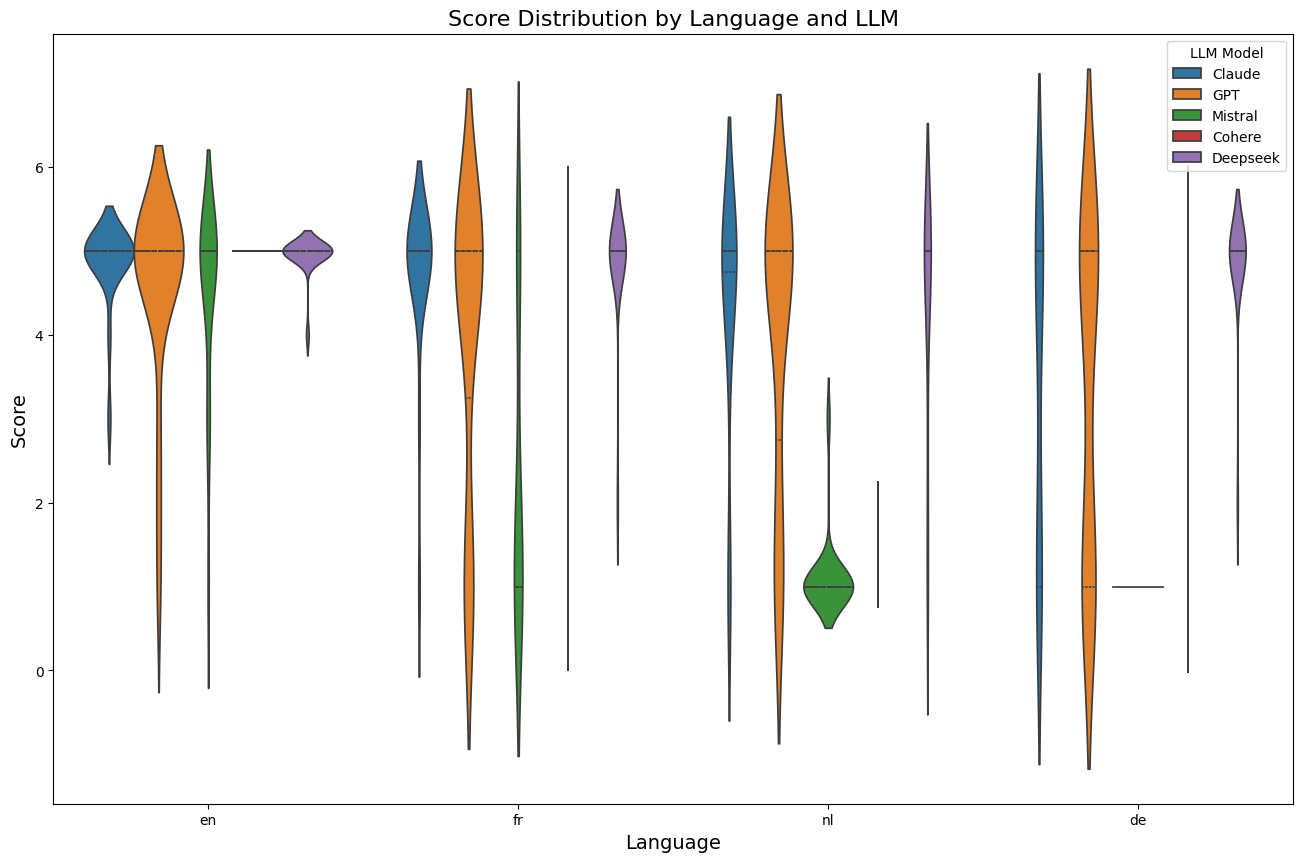

In [ ]:
# 5. Violin Plot of Performance by Language and LLM
plt.figure(figsize=(16, 10))
sns.violinplot(x='Language', y='score', hue='llm', data=df, split=False, inner='quartile')
plt.title('Score Distribution by Language and LLM', fontsize=16)
plt.xlabel('Language', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend(title='LLM Model')
plt.savefig('violin_by_language_and_llm.png', dpi=300, bbox_inches='tight')

In [ ]:
# 6. ANOVA for Language Effect
print("\nANOVA for Language Effect on Performance:")
lang_model = ols('score ~ Language', data=df).fit()
lang_anova = sm.stats.anova_lm(lang_model, typ=2)
print(lang_anova)


ANOVA for Language Effect on Performance:
             sum_sq     df          F        PR(>F)
Language   246.8075    3.0  27.871391  2.261575e-16
Residual  1168.8900  396.0        NaN           NaN


In [ ]:

# 7. Two-way ANOVA for Language and LLM Effect
print("\nTwo-way ANOVA for Language and LLM Effect on Performance:")
two_way_model = ols('score ~ Language + llm + Language:llm', data=df).fit()
two_way_anova = sm.stats.anova_lm(two_way_model, typ=2)
print(two_way_anova)



Two-way ANOVA for Language and LLM Effect on Performance:
                sum_sq     df          F        PR(>F)
Language      246.8075    3.0  59.541536  1.424192e-31
llm           467.0600    4.0  84.507571  2.806426e-51
Language:llm  176.7800   12.0  10.661905  2.774323e-18
Residual      525.0500  380.0        NaN           NaN


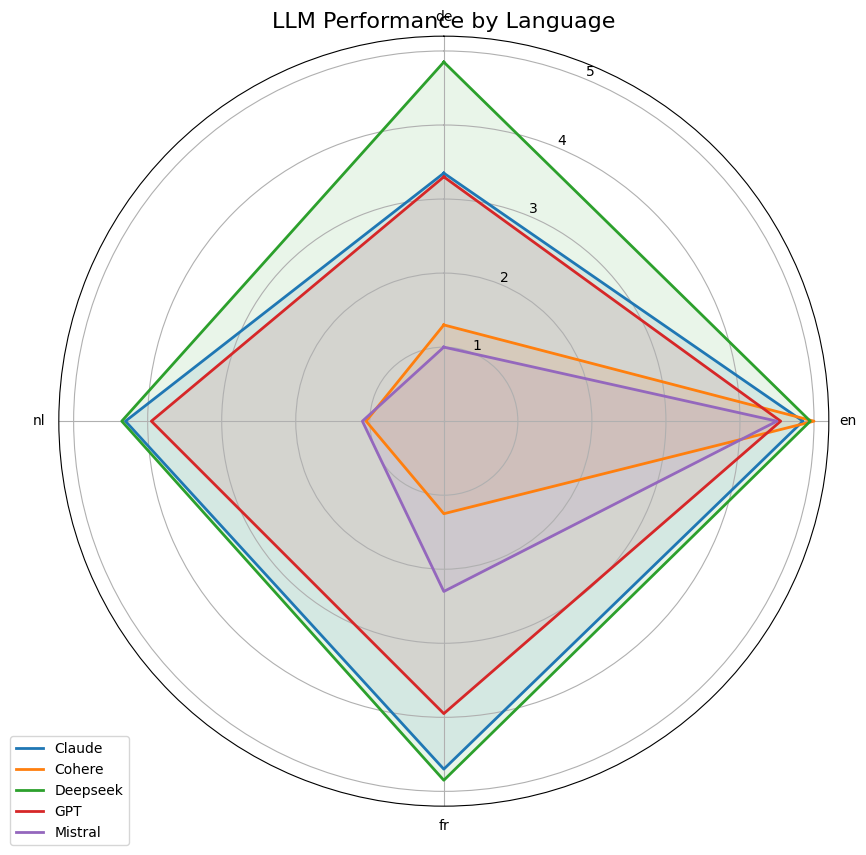

In [ ]:


# 8. Radar Chart of Language Performance by LLM
# First calculate mean score for each LLM in each language
radar_data = df.groupby(['llm', 'Language'])['score'].mean().unstack()

# Create the radar chart
plt.figure(figsize=(10, 10))
# Set up the plot
angles = np.linspace(0, 2*np.pi, len(radar_data.columns), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # Close the loop

# Initialize the plot
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Add language labels
plt.xticks(angles[:-1], radar_data.columns)

# Plot each LLM
for i, llm in enumerate(radar_data.index):
    values = radar_data.loc[llm].values.flatten()
    values = np.concatenate((values, [values[0]]))  # Close the loop
    ax.plot(angles, values, linewidth=2, label=llm)
    ax.fill(angles, values, alpha=0.1)

plt.title('LLM Performance by Language', fontsize=16)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.savefig('radar_language_performance.png', dpi=300, bbox_inches='tight')

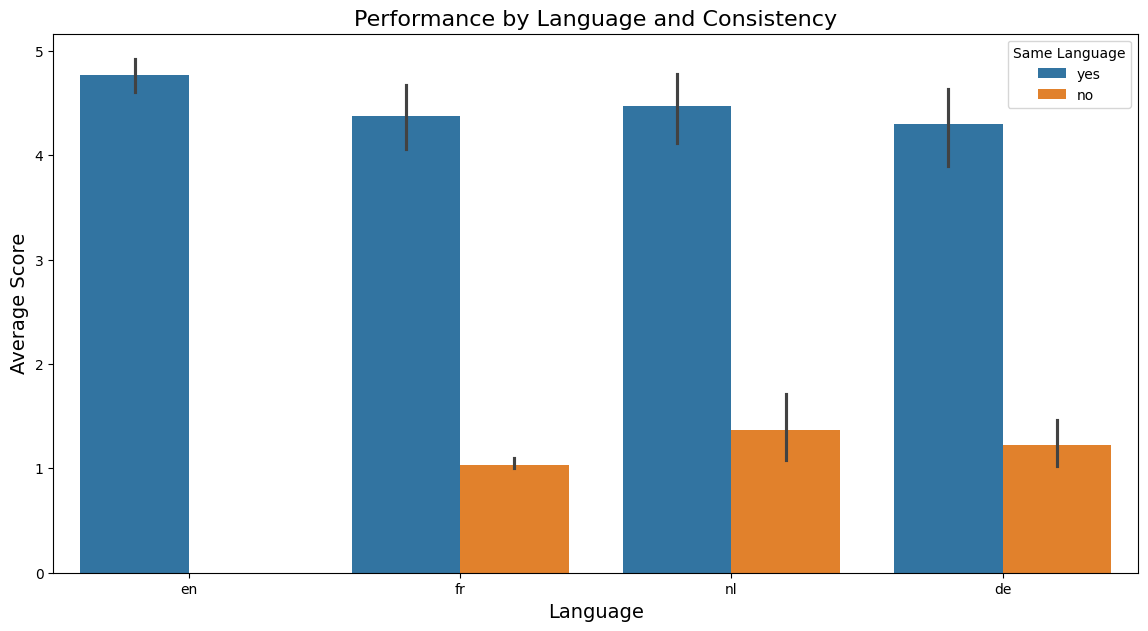

In [ ]:
# 9. Language Performance Grouped by Same/Different Language
plt.figure(figsize=(14, 7))
sns.barplot(x='Language', y='score', hue='QA_same_language', data=df)
plt.title('Performance by Language and Consistency', fontsize=16)
plt.xlabel('Language', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.legend(title='Same Language')
plt.savefig('performance_by_language_and_consistency.png', dpi=300, bbox_inches='tight')

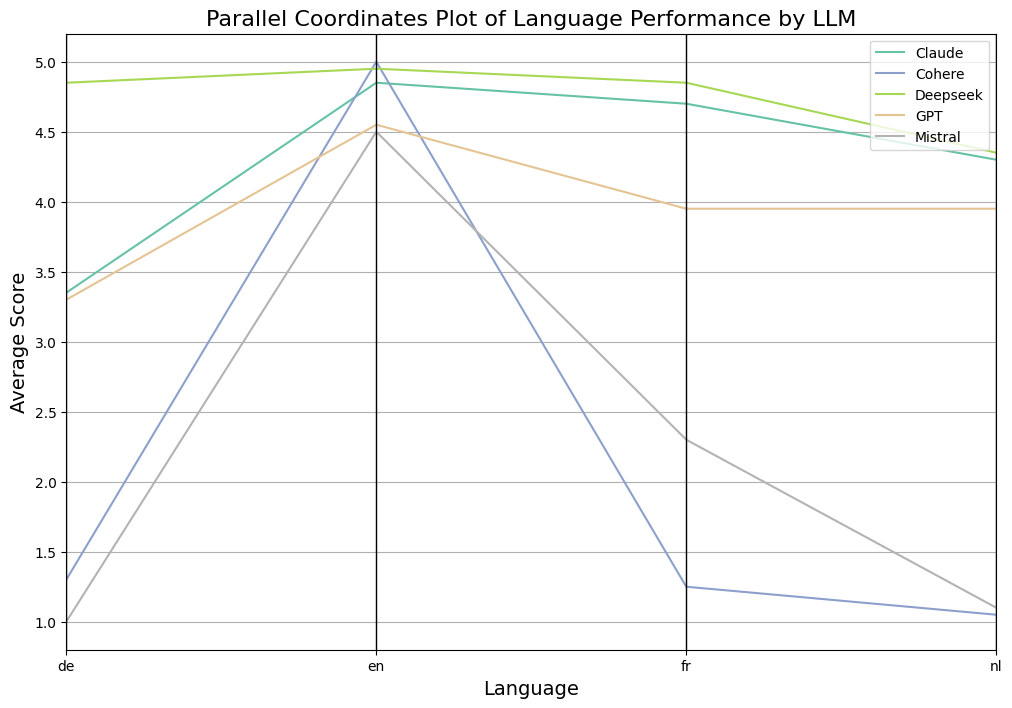

In [ ]:
# 10. Parallel Coordinates Plot for Multi-dimensional Analysis
# Setup data for parallel coordinates
parallel_df = df.groupby(['llm', 'Language'])['score'].mean().reset_index()
parallel_df_wide = parallel_df.pivot(index='llm', columns='Language', values='score').reset_index()

# Create the parallel coordinates plot
plt.figure(figsize=(12, 8))
pd.plotting.parallel_coordinates(parallel_df_wide, 'llm', colormap=plt.cm.Set2)
plt.title('Parallel Coordinates Plot of Language Performance by LLM', fontsize=16)
plt.xlabel('Language', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.grid(True)
plt.savefig('parallel_coordinates.png', dpi=300, bbox_inches='tight')


Performance Change from English Baseline:
          baseline_score  fr_score  fr_abs_change  fr_pct_change  nl_score  \
Claude              4.85      4.70          -0.15      -3.092784      4.30   
GPT                 4.55      3.95          -0.60     -13.186813      3.95   
Mistral             4.50      2.30          -2.20     -48.888889      1.10   
Cohere              5.00      1.25          -3.75     -75.000000      1.05   
Deepseek            4.95      4.85          -0.10      -2.020202      4.35   

          nl_abs_change  nl_pct_change  de_score  de_abs_change  de_pct_change  
Claude            -0.55     -11.340206      3.35          -1.50     -30.927835  
GPT               -0.60     -13.186813      3.30          -1.25     -27.472527  
Mistral           -3.40     -75.555556      1.00          -3.50     -77.777778  
Cohere            -3.95     -79.000000      1.30          -3.70     -74.000000  
Deepseek          -0.60     -12.121212      4.85          -0.10      -2.020202  


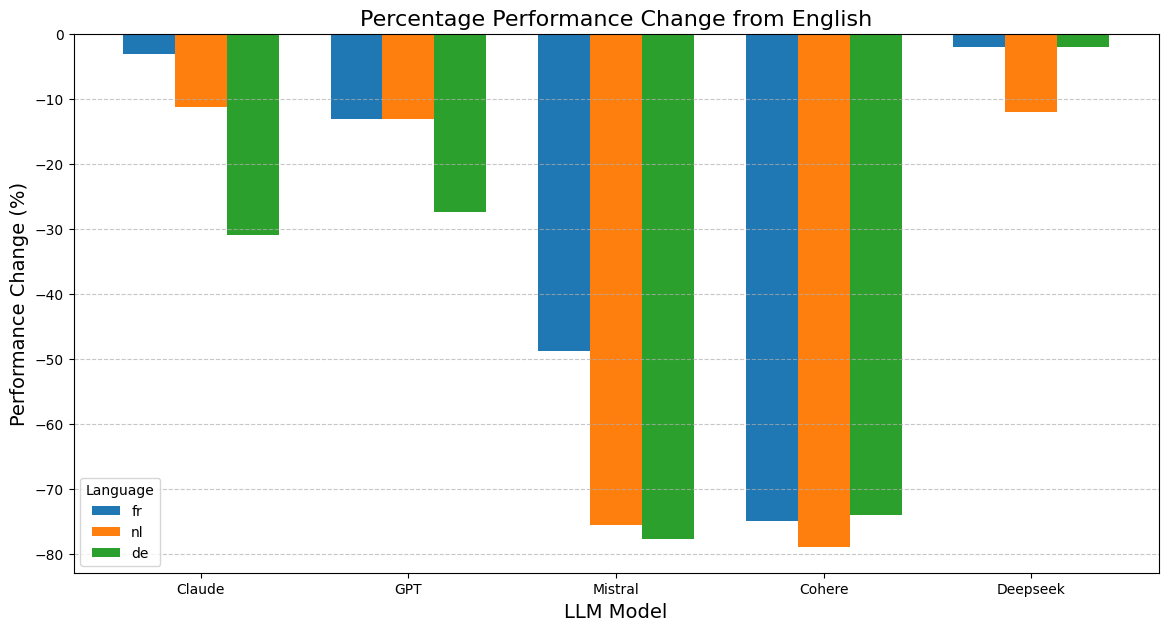

In [ ]:
# 11. Language-specific Performance Change Analysis
# Calculate percentage change from English (baseline) to other languages for each LLM
baseline_lang = 'en'
langs = df['Language'].unique()
other_langs = [lang for lang in langs if lang != baseline_lang]

# Create empty dataframe for results
perf_change = pd.DataFrame(index=df['llm'].unique())

# Calculate baseline performance (English)
baseline_perf = df[df['Language'] == baseline_lang].groupby('llm')['score'].mean()
perf_change['baseline_score'] = baseline_perf

# Calculate performance change for each language
for lang in other_langs:
    lang_perf = df[df['Language'] == lang].groupby('llm')['score'].mean()
    perf_change[f'{lang}_score'] = lang_perf
    perf_change[f'{lang}_abs_change'] = perf_change[f'{lang}_score'] - perf_change['baseline_score']
    perf_change[f'{lang}_pct_change'] = (perf_change[f'{lang}_abs_change'] / perf_change['baseline_score']) * 100

print("\nPerformance Change from English Baseline:")
print(perf_change)

# Visualize performance change from English to other languages
plt.figure(figsize=(14, 7))
for lang in other_langs:
    plt.bar(
        x=[i + (other_langs.index(lang) * 0.25) for i in range(len(perf_change.index))],
        height=perf_change[f'{lang}_pct_change'],
        width=0.25,
        label=lang
    )

plt.title('Percentage Performance Change from English', fontsize=16)
plt.xlabel('LLM Model', fontsize=14)
plt.ylabel('Performance Change (%)', fontsize=14)
plt.xticks([i + 0.25 for i in range(len(perf_change.index))], perf_change.index)
plt.legend(title='Language')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.savefig('performance_change_from_english.png', dpi=300, bbox_inches='tight')


Language Difficulty (with standard deviation):
  Language score                
            mean       std count
0       de  2.76  1.944274   100
1       en  4.77  0.763498   100
2       fr  3.41  1.917990   100
3       nl  2.95  1.940400   100

Correlations Between Same LLM Across Languages:
Claude: en-fr correlation: nan
Claude: en-nl correlation: nan
Claude: fr-nl correlation: nan
Claude: de-en correlation: nan
Claude: de-fr correlation: nan
Claude: de-nl correlation: nan
GPT: en-fr correlation: nan
GPT: en-nl correlation: nan
GPT: fr-nl correlation: nan
GPT: de-en correlation: nan
GPT: de-fr correlation: nan
GPT: de-nl correlation: nan
Mistral: en-fr correlation: nan
Mistral: en-nl correlation: nan
Mistral: fr-nl correlation: nan
Mistral: de-en correlation: nan
Mistral: de-fr correlation: nan
Mistral: de-nl correlation: nan
Cohere: en-fr correlation: nan
Cohere: en-nl correlation: nan
Cohere: fr-nl correlation: nan
Cohere: de-en correlation: nan
Cohere: de-fr correlation: nan
Cohe

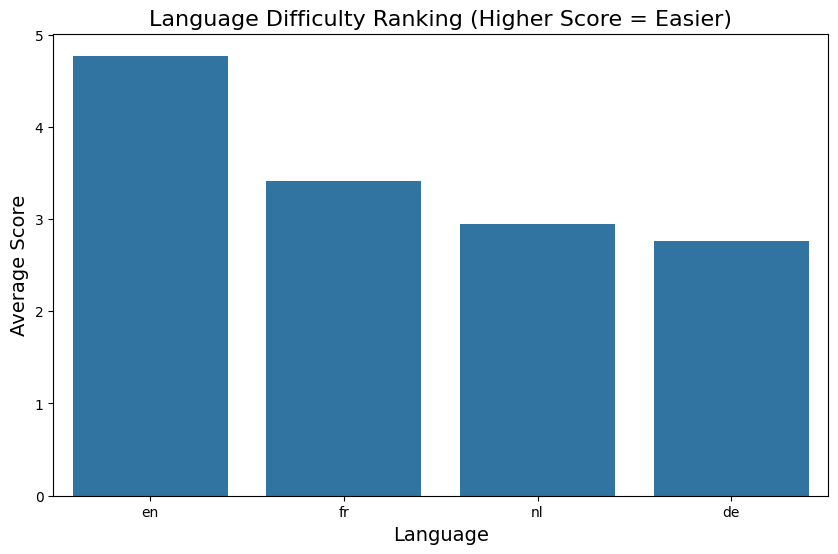

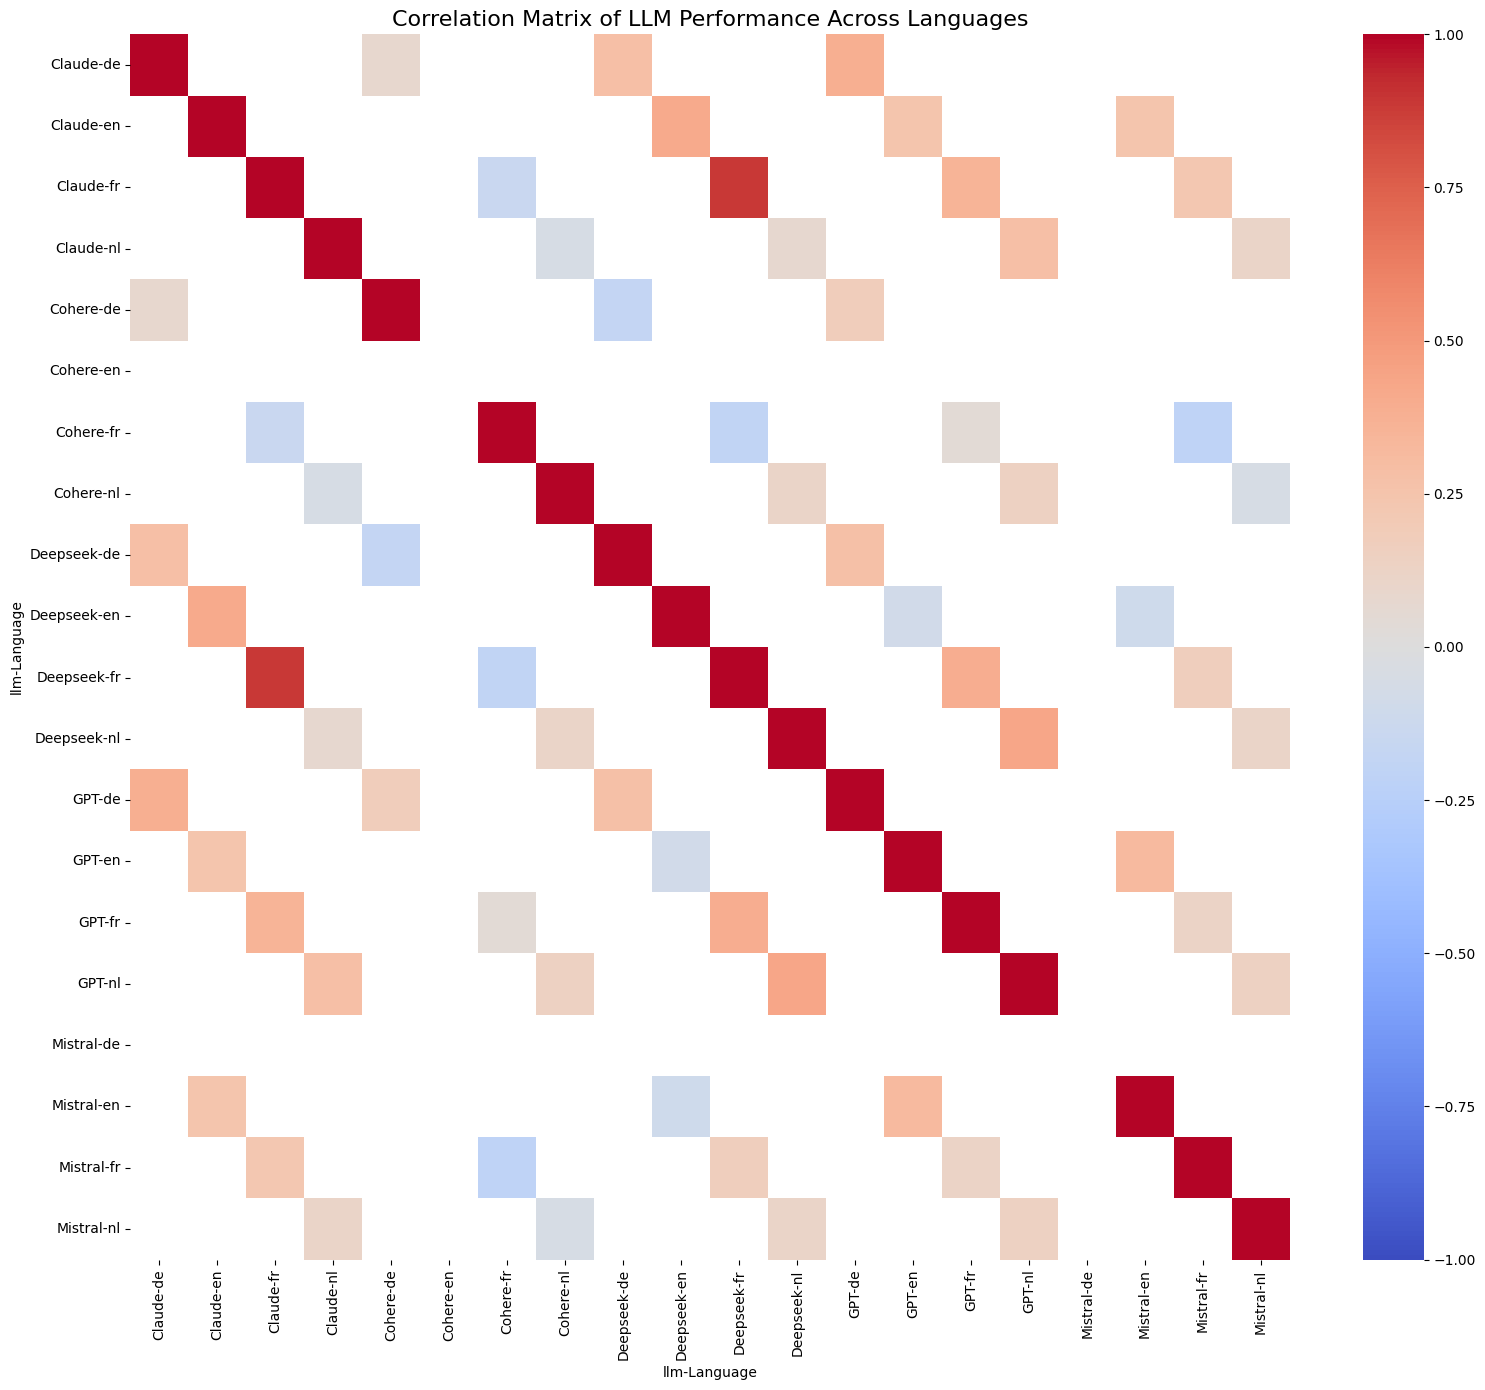

In [ ]:

# 12. Language Difficulty Ranking
# Calculate average score for each language
lang_difficulty = df.groupby('Language')['score'].mean().reset_index()
lang_difficulty = lang_difficulty.sort_values('score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Language', y='score', data=lang_difficulty, order=lang_difficulty['Language'])
plt.title('Language Difficulty Ranking (Higher Score = Easier)', fontsize=16)
plt.xlabel('Language', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.savefig('language_difficulty_ranking.png', dpi=300, bbox_inches='tight')


# Add standard deviation to see consistency
lang_difficulty_with_std = df.groupby('Language').agg({
    'score': ['mean', 'std', 'count']
}).reset_index()
print("\nLanguage Difficulty (with standard deviation):")
print(lang_difficulty_with_std)

# 13. Correlation Matrix of Performance Across Languages
# Create a correlation matrix of how LLM performance correlates across languages
model_lang_matrix = df.pivot_table(values='score', index='question_id', columns=['llm', 'Language'], aggfunc='mean')
correlation_matrix = model_lang_matrix.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of LLM Performance Across Languages', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')


# Print key correlations between same model across languages
print("\nCorrelations Between Same LLM Across Languages:")
for llm in df['llm'].unique():
    for lang1 in langs:
        for lang2 in langs:
            if lang1 < lang2:  # Avoid duplicate combinations
                try:
                    corr_value = correlation_matrix.loc[(llm, lang1), (llm, lang2)]
                    print(f"{llm}: {lang1}-{lang2} correlation: {corr_value:.4f}")
                except KeyError:
                    pass  # Skip if combination doesn't exist

In [ ]:
# 4. Heat Map of Performance
# Extract question number from question_id
df['question_num'] = df['question_id'].str.extract(r'q(\d+)_').astype(int)

# Create pivot table for heatmap
pivot_data = df.pivot_table(values='score', index='llm', columns='question_num', aggfunc='mean')

plt.figure(figsize=(20, 8))
sns.heatmap(pivot_data, annot=True, cmap='YlGnBu', linewidths=.5)
plt.title('Average Score by LLM and Question Number', fontsize=16)
plt.xlabel('Question Number', fontsize=14)
plt.ylabel('LLM Model', fontsize=14)
plt.savefig('performance_heatmap.png', dpi=300, bbox_inches='tight')
plt.close()

In [ ]:





# 5. Statistical Analysis
# a. Paired t-tests for same language vs different language
print("T-tests for Same vs Different Language Performance:")
results_t_tests = {}

for model in df['llm'].unique():
    model_data = df[df['llm'] == model]
    same_lang = model_data[model_data['same_language'] == True]['score']
    diff_lang = model_data[model_data['same_language'] == False]['score']

    # Only perform t-test if we have data for both conditions
    if len(same_lang) > 0 and len(diff_lang) > 0:
        t_stat, p_val = stats.ttest_ind(same_lang, diff_lang, equal_var=False)
        results_t_tests[model] = {'t_statistic': t_stat, 'p_value': p_val}
        print(f"{model}: t={t_stat:.4f}, p={p_val:.4f}")

# b. ANOVA to compare LLM performance
print("\nANOVA for Overall LLM Performance:")
model = ols('score ~ llm', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# c. Chi-square test for high scores and language consistency
print("\nChi-square test for High Scores and Language Consistency:")
# Create contingency table
df['high_score'] = df['score'] >= 4  # Define high score as 4 or 5
contingency = pd.crosstab(df['high_score'], df['same_language'])
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print(f"Chi2={chi2:.4f}, p={p:.4f}, dof={dof}")

# 6. Performance Over Question Types
plt.figure(figsize=(15, 8))
sns.lineplot(x='question_num', y='score', hue='llm', data=df, marker='o')
plt.title('Performance Across Question Types', fontsize=16)
plt.xlabel('Question Number', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.legend(title='LLM Model')
plt.savefig('performance_by_question.png', dpi=300, bbox_inches='tight')
plt.close()

# 7. Correlation Analysis
# Calculate point-biserial correlation (correlation between binary and continuous variable)
correlation = stats.pointbiserialr(df['same_language'], df['score'])
print("\nCorrelation between Same Language and Score:")
print(f"r={correlation[0]:.4f}, p={correlation[1]:.4f}")

# Additional Analysis: Performance by LLM and Language Consistency
# Create a grouped dataframe for better visualization
grouped_df = df.groupby(['llm', 'QA_same_language']).agg(
    mean_score=('score', 'mean'),
    std_score=('score', 'std'),
    count=('score', 'count')
).reset_index()

print("\nPerformance Summary by LLM and Language Consistency:")
print(grouped_df)

# Create a more detailed bar chart with error bars - FIX: updated errwidth parameter
plt.figure(figsize=(14, 7))
sns.barplot(x='llm', y='mean_score', hue='QA_same_language', data=grouped_df,
           edgecolor='black', err_kws={'linewidth': 1.5}, capsize=0.1,
           palette=["#3498db", "#e74c3c"])
plt.title('Average Score by LLM and Language Consistency', fontsize=16)
plt.xlabel('LLM Model', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.legend(title='Same Language')
plt.savefig('detailed_performance_by_language.png', dpi=300, bbox_inches='tight')
plt.close()

# Violin plots to show distribution
plt.figure(figsize=(14, 7))
sns.violinplot(x='llm', y='score', hue='QA_same_language', data=df, split=True, inner='quartile')
plt.title('Score Distribution by LLM and Language Consistency', fontsize=16)
plt.xlabel('LLM Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend(title='Same Language')
plt.savefig('violin_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

# Calculate and display performance drop percentage
same_lang_perf = df[df['same_language'] == True].groupby('llm')['score'].mean()
diff_lang_perf = df[df['same_language'] == False].groupby('llm')['score'].mean()

# FIX: Convert set to list for models_with_both
models_with_both = list(set(same_lang_perf.index) & set(diff_lang_perf.index))
perf_drop = pd.DataFrame(index=models_with_both)
perf_drop['same_lang_avg'] = same_lang_perf
perf_drop['diff_lang_avg'] = diff_lang_perf
perf_drop['abs_drop'] = perf_drop['same_lang_avg'] - perf_drop['diff_lang_avg']
perf_drop['pct_drop'] = (perf_drop['abs_drop'] / perf_drop['same_lang_avg']) * 100

print("\nPerformance Drop Analysis:")
print(perf_drop)

# Visualize performance drop
plt.figure(figsize=(12, 6))
sns.barplot(x=perf_drop.index, y=perf_drop['pct_drop'])
plt.title('Percentage Performance Drop in Different Language Queries', fontsize=16)
plt.xlabel('LLM Model', fontsize=14)
plt.ylabel('Performance Drop (%)', fontsize=14)
plt.savefig('performance_drop.png', dpi=300, bbox_inches='tight')
plt.close()

T-tests for Same vs Different Language Performance:
Claude: t=4.8620, p=0.0003
GPT: t=9.9834, p=0.0000
Mistral: t=8.3078, p=0.0000
Cohere: t=51.9777, p=0.0000
Deepseek: t=4.7807, p=0.0395

ANOVA for Overall LLM Performance:
            sum_sq     df          F        PR(>F)
llm       467.0600    4.0  48.619388  3.028475e-33
Residual  948.6375  395.0        NaN           NaN

Chi-square test for High Scores and Language Consistency:
Chi2=236.5814, p=0.0000, dof=1


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



Correlation between Same Language and Score:
r=0.8161, p=0.0000

Performance Summary by LLM and Language Consistency:
        llm QA_same_language  mean_score  std_score  count
0    Claude               no    2.230769   1.786703     13
1    Claude              yes    4.701493   0.921378     67
2    Cohere               no    1.135593   0.571074     59
3    Cohere              yes    5.000000   0.000000     21
4  Deepseek               no    1.666667   1.154701      3
5  Deepseek              yes    4.870130   0.592733     77
6       GPT               no    1.285714   1.069045     14
7       GPT              yes    4.500000   1.205755     66
8   Mistral               no    1.000000   0.000000     39
9   Mistral              yes    3.390244   1.842255     41

Performance Drop Analysis:
          same_lang_avg  diff_lang_avg  abs_drop   pct_drop
Cohere         5.000000       1.135593  3.864407  77.288136
Deepseek       4.870130       1.666667  3.203463  65.777778
GPT            4.500000 